In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\robotics\anaconda3\envs\faster_rcnn\l

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11783134298711632618,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7030246605
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15846330804577445662
 physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5"]

In [1]:
import scipy
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from PIL import Image
import math

downsize = 2 #5/3
Highimgsize = (576,768) #
class DataLoader():
    def __init__(self, dataset_name, img_res=Highimgsize):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, batch_size=1, is_testing=False):
        # random.seed(0)
        # np.random.seed(0)
        data_type = "train1" if not is_testing else "test"

        files = glob.glob("train/*.png", recursive=True)
        batch_images = random.sample(files, batch_size)

        imgs_hr = []
        imgs_lr = []
        for img_path in batch_images:
            img = Image.open(img_path)
            print(img.size)
            h, w = self.img_res
            
            low_h, low_w = int(h / downsize), int(w / downsize)

            img_hr = img.resize((w, h))  #(64, 64)
            img_lr = img.resize((low_w, low_h))
            img_hr = np.array(img_hr)
            #img_hr = (img_hr - 127.5) / 127.5
            img_lr = np.array(img_lr)
            #img_lr = (img_lr - 127.5) / 127.5

            if not is_testing and np.random.random() < 0.5:
                img_hr = np.fliplr(img_hr)
                img_lr = np.fliplr(img_lr)

            imgs_hr.append(img_hr)
            imgs_lr.append(img_lr)

        imgs_hr = np.array(imgs_hr) / 127.5 - 1.
        imgs_lr = np.array(imgs_lr) / 127.5 - 1.

        return imgs_hr, imgs_lr

In [2]:
class predDataLoader():          
    def load_data(self, batch_size,cnt):
        random.seed(cnt)
        np.random.seed(cnt)

        files = glob.glob("test/*.png", recursive=True)
        batch_images = random.sample(files, batch_size)

        imgs_or = []
        for img_path in batch_images:
            img = Image.open(img_path)

            img_or = np.array(img)
            imgs_or.append(img_or)

        imgs_or = np.array(imgs_or) / 127.5 - 1.

        return imgs_or

In [3]:
#%tensorflow_version 1.x
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
# from data_loader import DataLoader
import numpy as np
import os
import csv
import keras.backend as K

class SRGAN():
    def __init__(self):
        # Input shape
        self.channels = 3
        self.lr_height = 288                 # Low resolution height
        self.lr_width = 384                  # Low resolution width
        self.lr_shape = (self.lr_height, self.lr_width, self.channels)
        resLevel = 2 #
        self.hr_height = self.lr_height*resLevel  # High resolution height
        self.hr_width = self.lr_width*resLevel     # High resolution width
        self.hr_shape = (self.hr_height, self.hr_width, self.channels)

        #残差ブロックの数
        # Number of residual blocks in the generator
        self.n_residual_blocks = 16 #

        optimizer = Adam(0.0002, 0.5)

        #img_hrの特徴量をVGG19で算出する
        # We use a pre-trained VGG19 model to extract image features from the high resolution
        # and the generated high resolution images and minimize the mse between them
        self.vgg = self.build_vgg()
        self.vgg.trainable = False
        self.vgg.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        
        #データはここで読み込まれる
        # Configure data loader
        self.dataset_name = 'img_align_celeba'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.hr_height, self.hr_width))
        self.pred_data_loader = predDataLoader()

        #Dのサイズ
        # Calculate output shape of D (PatchGAN)
        patchH = int(self.hr_height / 2**4) #
        patchW = int(self.hr_width / 2**4) #
        self.disc_patch = (patchH, patchW, 1) 

        #DとGのチャンネル設定
        # Number of filters in the first layer of G and D
        self.gf = 60 #
        self.df = 60 #
        #Dビルドとコンパイル
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #Gのビルド
        # Build the generator
        self.generator = self.build_generator()

        # High res. and low res. images
        img_hr = Input(shape=self.hr_shape)
        img_lr = Input(shape=self.lr_shape)

        #Gで生成されたhrのimg
        # Generate high res. version from low res.
        fake_hr = self.generator(img_lr)

        #hrのimgの特徴量の算出
        # Extract image features of the generated img
        fake_features = self.vgg(fake_hr)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        #学習モデルコンパイル
        # Discriminator determines validity of generated high res. images
        validity = self.discriminator(fake_hr)

        self.combined = Model([img_lr, img_hr], [validity, fake_features])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-3, 1],
                              optimizer=optimizer)


    def build_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features extracted at the
        third block of the model
        """
        vgg = VGG19(weights="imagenet")
        # Set outputs to outputs of last conv. layer in block 3
        # See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
        vgg.outputs = [vgg.layers[9].output]

        img = Input(shape=self.hr_shape)

        # Extract image features
        img_features = vgg(img)

        return Model(img, img_features)

    #Gの中身
    def build_generator(self):

        #残差ブロックの中身
        def residual_block(layer_input, filters):
            """Residual block described in paper"""
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        #解像度を2倍にするUpSampling
        def deconv2d(layer_input):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input) #
            u = Conv2D(120, kernel_size=3, strides=1, padding='same')(u) #
            u = Activation('relu')(u)
            return u

        # Low resolution image input
        img_lr = Input(shape=self.lr_shape)

        # Pre-residual block
        c1 = Conv2D(60, kernel_size=9, strides=1, padding='same')(img_lr) #
        c1 = Activation('relu')(c1)

        # Propogate through residual blocks
        r = residual_block(c1, self.gf)
        for _ in range(self.n_residual_blocks - 1):
            r = residual_block(r, self.gf)

        #去の残差ブロックと組み合わせる
        # Post-residual block
        c2 = Conv2D(60, kernel_size=3, strides=1, padding='same')(r) #
        c2 = BatchNormalization(momentum=0.8)(c2)
        c2 = Add()([c2, c1])

        # Upsampling
        u2 = deconv2d(c2)
        #u2 = deconv2d(u1)

        # Generate high resolution output
        gen_hr = Conv2D(self.channels, kernel_size=9, strides=1, padding='same', activation='tanh')(u2)

        return Model(img_lr, gen_hr)
    #Dの中身
    def build_discriminator(self):

        
        def d_block(layer_input, filters, strides=1, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        # Input img
        d0 = Input(shape=self.hr_shape)
        #畳み込み層、チャンネル数を最終的に16倍に
        d1 = d_block(d0, self.df, bn=False)
        d2 = d_block(d1, self.df, strides=2)
        d3 = d_block(d2, self.df*2)
        d4 = d_block(d3, self.df*2, strides=2)
        d5 = d_block(d4, self.df*4)
        d6 = d_block(d5, self.df*4, strides=2)
        d7 = d_block(d6, self.df*8)
        d8 = d_block(d7, self.df*8, strides=2)
        #この時点で画像サイズ1/16
        d9 = Dense(self.df*16)(d8)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validity = Dense(1, activation='sigmoid')(d10)

        return Model(d0, validity)

    #学習
    def train(self, epochs, batch_size, sample_interval=100):

        start_time = datetime.datetime.now()
        psnr_file = open('psnr.csv' , 'w+')
        psnr_file.close()

        for epoch in range(epochs):

            # ----------------------
            #  Train Discriminator
            # ----------------------

            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.data_loader.load_data(batch_size)

            # From low res. image generate high res. version
            fake_hr = self.generator.predict(imgs_lr)

            valid = np.ones((batch_size,) + self.disc_patch)
            fake = np.zeros((batch_size,) + self.disc_patch)

            #Dのloss
            # Train the discriminators (original images = real / generated = Fake)
            d_loss_real = self.discriminator.train_on_batch(imgs_hr, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_hr, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ------------------
            #  Train Generator
            # ------------------

            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.data_loader.load_data(batch_size)

            # The generators want the discriminators to label the generated images as real
            valid = np.ones((batch_size,) + self.disc_patch)

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = self.vgg.predict(imgs_hr)

            # Train the generators
            g_loss = self.combined.train_on_batch([imgs_lr, imgs_hr], [valid, image_features])

            elapsed_time = datetime.datetime.now() - start_time
            # Plot the progress
            print ("%d time: %s" % (epoch, elapsed_time))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                self.generator.save_weights('srg_weight.h5')

    def sample_images(self, epoch):
        def denormalize(input_data):
            input_data = (input_data + 1) * 127.5
            return input_data.astype(np.uint8)
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 2

        imgs_hr, imgs_lr = self.data_loader.load_data(batch_size=2, is_testing=True)
        fake_hr = self.generator.predict(imgs_lr)

        imgs_lr = denormalize(imgs_lr)
        fake_hr = denormalize(fake_hr)
        imgs_hr = denormalize(imgs_hr)

        def psnr_calc(img1: np.ndarray, img2: np.ndarray, upscaling=2):
            def convert(img):
                return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            def extract_y(image: np.ndarray) -> np.ndarray:
                if image.ndim == 2:
                    return image
                image = image.astype(np.int32)
                return ((image[:, :, 2] * 65.481 / 255.
                          + image[:, :, 1] * 128.553 / 255.
                          + image[:, :, 0] * 24.966 / 255.) + 16).astype(np.int32)


            def psnr(img1, img2):
                mse = np.mean((img1 - img2) ** 2)
                if mse == 0:
                    return 100
                PIXEL_MAX = 255.0
                return 10 * math.log10(PIXEL_MAX * PIXEL_MAX / mse)
  
            img1_conv=convert(img1)
            img2_conv=convert(img2)
  
            # BGR -> YCrCb
            # 画像はcv2.imreadで読まれている前提 [0, 255]
            y1 = extract_y(img1_conv)
            y2 = extract_y(img2_conv)
            # 周囲のcropping
            # assert y1.shape == y2.shape
            h, w = y1.shape
            cr = upscaling
            cropped_y1 = y1[cr:h - cr, cr:w - cr].astype(np.float64)
            cropped_y2 = y2[cr:h - cr, cr:w - cr].astype(np.float64)

            # psnr
            psnr_val = psnr(cropped_y1, cropped_y2)
            return psnr_val

        # Save generated images and the high resolution originals
        titles = ['Generated', 'Original']

        cv2.imwrite("images/hreal_img_0.png",imgs_hr[0])
        cv2.imwrite("images/hreal_img_1.png",imgs_hr[1])
        cv2.imwrite("images/lreal_img_0.png",imgs_lr[0])
        cv2.imwrite("images/lreal_img_1.png",imgs_lr[1])
        # size=(480,480)

        for i in range(r):
            psnr = psnr_calc(imgs_hr[i],fake_hr[i])
            print(psnr)
            data =[epoch,psnr]
            psnr_file = open('psnr.csv' , 'a')
            writer = csv.writer(psnr_file, lineterminator='\n')  
            writer.writerow(data)
            psnr_file.close()
            cv2.imwrite("images/{}_{}img_pred.png".format(epoch,i),fake_hr[i])
            
    

Using TensorFlow backend.
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\robotics\an

In [10]:
if __name__ == '__main__':
    gan = SRGAN()
    gan.train(epochs=51, batch_size=1, sample_interval=50)

(640, 480)
(640, 480)
0 time: 0:00:20.810015
(640, 480)
(640, 480)
10.698470030972715
14.282209329617455
(640, 480)
(640, 480)
1 time: 0:01:01.191068
(640, 480)
(640, 480)
2 time: 0:01:02.264898
(640, 480)
(640, 480)
3 time: 0:01:03.368845
(640, 480)
(640, 480)
4 time: 0:01:04.456708
(640, 480)
(640, 480)
5 time: 0:01:05.551773
(640, 480)
(640, 480)
6 time: 0:01:06.638367
(640, 480)
(640, 480)
7 time: 0:01:07.731361
(640, 480)
(640, 480)
8 time: 0:01:08.809980
(640, 480)
(640, 480)
9 time: 0:01:09.913112
(640, 480)
(640, 480)
10 time: 0:01:10.998577
(640, 480)
(640, 480)
11 time: 0:01:12.092887
(640, 480)
(640, 480)
12 time: 0:01:13.192639
(640, 480)
(640, 480)
13 time: 0:01:14.264452
(640, 480)
(640, 480)
14 time: 0:01:15.376456
(640, 480)
(640, 480)
15 time: 0:01:16.467580
(640, 480)
(640, 480)
16 time: 0:01:17.564385
(640, 480)
(640, 480)
17 time: 0:01:18.648721
(640, 480)
(640, 480)
18 time: 0:01:19.756058
(640, 480)
(640, 480)
19 time: 0:01:20.846877
(640, 480)
(640, 480)
20 time:

In [11]:
with open('psnr.csv') as f:
    reader = csv.reader(f)
    psnr_array1=[]
    psnr_array2=[]
    epoch_array1=[]
    epoch_array2=[]
    cnt=1
    for row in reader:
        if(cnt%2 is 1):
          psnr_array1.append(float(row[1]))
          epoch_array1.append(int(row[0]))
        else:
          psnr_array2.append(float(row[1]))
          epoch_array2.append(int(row[0]))
        cnt+=1

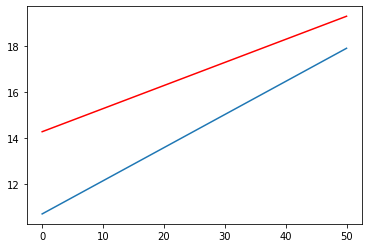

In [12]:
import matplotlib.pyplot as plt
plt.plot(epoch_array1, psnr_array1)
plt.plot(epoch_array2, psnr_array2,color='red')

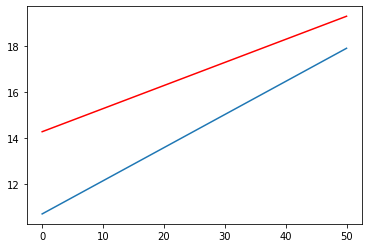

In [13]:
import matplotlib.pyplot as plt
plt.plot(epoch_array1, psnr_array1)
plt.plot(epoch_array2, psnr_array2,color='red')

In [14]:
with open('psnr.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        print(row)

['0', '10.698470030972715']
['0', '14.282209329617455']
['50', '17.91898684712699']
['50', '19.31549043529526']


評価

In [15]:
class Generate(SRGAN):
    def generate(self, batch_size=1, sample_interval=50):
        BATCH_SIZE=1
        ite=10000
        def denormalize(input_data):
            input_data = (input_data + 1) * 127.5
            return input_data.astype(np.uint8)
            
        self.generator = self.build_generator()
        g = self.generator
        g.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
        g.load_weights('srg_weight.h5')
        for i in range(10):
            noise = np.random.uniform(size=[BATCH_SIZE, 288*384*3], low=-1.0, high=1.0)
            imgs_or = self.pred_data_loader.load_data(batch_size=1,cnt=i)
            # imgs_hr, imgs_or = self.data_loader.load_data(batch_size=BATCH_SIZE,is_testing=True)

            plt.imshow(denormalize(imgs_or[0]))
            plt.pause(1)
            noise=imgs_or.reshape(BATCH_SIZE,288,384,3)
            generated_images = g.predict(noise)
            plt.imshow(denormalize(generated_images[0]))
            plt.pause(1)
            p_im=Image.fromarray(denormalize(generated_images[0]))
            p_im.save('output/p_im_{}.png'.format(i))
            # plt.imshow(p_im.resize((120,120)), Image.LANCZOS)

            print(i)
        # os.makedirs(os.path.join(".", "images"), exist_ok=True)
        # image.save("./images/%s%d.png" % (ite,i))            

    def combine_images(generated_images, cols=5, rows=5):
        shape = generated_images.shape
        h = shape[1]
        w = shape[2]
        image = np.zeros((rows * h,  cols * w, 3))
        for index, img in enumerate(generated_images):
            if index >= cols * rows:
                break
            i = index // cols
            j = index % cols
            image[i*h:(i+1)*h, j*w:(j+1)*w, :] = img[:, :, :]
        image = image * 127.5 + 127.5
        image = Image.fromarray(image.astype(np.uint8))
        return image

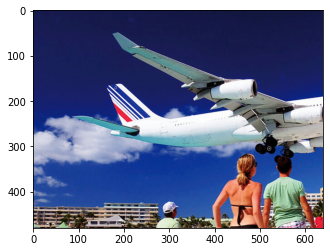

ValueError: cannot reshape array of size 921600 into shape (1,288,384,3)

In [16]:
if __name__ == '__main__':
    gene = Generate()
    gene.generate(batch_size=1, sample_interval=1000)

In [20]:
img = Image.open('p_im_1.jpg')

img_resize_lanczos = img.resize((120, 120), Image.LANCZOS)
plt.imshow(img_resize_lanczos)
plt.pause(1)

FileNotFoundError: [Errno 2] No such file or directory: 'p_im_1.jpg'

In [21]:
import cv2
import numpy as np
import glob

cropfiles = glob.glob("output/crop/*")
imgcount = 0
reH = 288
reW = 384
for f in cropfiles:
    img = cv2.imread(f)
    imgH, imgW = img.shape[:2]
    cropimg = img[int(imgH/2-reH/2):int(imgH/2+reH/2), int(imgW/2-reW/2):int(imgW/2+reW/2)]
    f1 = "test/"+str(imgcount)+".png"
    cv2.imwrite(f1,cropimg)
    imgcount += 1
    